The script is used to evaluate the error of PCE-----Created on 2021/05/12 by Qian Wang

In [3]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
# import latex
rc("text", usetex=False)

from basic.read_data import read_specify, file_settings
from basic.utils import dist_return

In [2]:
# Import settings of PCE
from error_fixing import fix_group_ranking
input_path = file_settings()[1]
output_path = file_settings()[0]
output_path = '../output/adaptive/'
samples, values = read_specify('model', 'reduced', 
    product_uniform=False, num_vars=11)
samples_22, _ = read_specify('model', 'full', 
    product_uniform=False, num_vars=22)
values_vali = values[450:]
samples_vali = samples[:, 450:]
samples_22_vali = samples_22[:, 450:]

In [4]:
# Calculate the error (RMSE) of PCE
product_uniform = ['exact', 'uniform', False] #, 'uniform'
rmse_all = {}
for p in product_uniform:
    dist_type = dist_return(p)
    filename = f'adaptive-reduce-{dist_type}_552'
    print(filename)
    approx_list_all = pickle.load(open(f'{output_path}{filename}-approx-list.pkl', "rb"))
    rmse_exact = pd.DataFrame(columns = np.arange(30, 450, 10), index=np.arange(0, 100, 1))

    for key, value in approx_list_all.items():
        rmse_temp = []
        nsample = int(key.split('_')[1])
        if (nsample >= 30) and (nsample <= 450):
            for pce in value:
                if dist_type == 'full':
                    y_hat = pce(samples_22_vali)
                else:
#                     breakpoint()
                    y_hat = pce(samples_vali)
                rmse_abs = (((y_hat.flatten()-values_vali.flatten())**2).mean())**0.5
                rmse_temp.append(rmse_abs / values_vali.std())
            rmse_exact.loc[0:(len(rmse_temp)-1), nsample] = rmse_temp
#     rmse_exact = pd.DataFrame.from_dict(rmse_exact)
    rmse_all[dist_type] = rmse_exact.mean(axis=0)
    rmse_all[dist_type + '_min'] = rmse_exact.min(axis=0)
    rmse_all[dist_type + '_max'] = rmse_exact.max(axis=0)

adaptive-reduce-exact_552
adaptive-reduce-uniform_552
adaptive-reduce-full_552


In [5]:
df = pd.DataFrame.from_dict(rmse_all).dropna()
df = df.reset_index()
df.tail(5)

,index,exact,exact_min,exact_max,uniform,uniform_min,uniform_max,full,full_min,full_max
38,410,0.061236,0.060475,0.062233,0.061642,0.061008,0.062714,0.080122,0.078499,0.082202
39,420,0.059222,0.058393,0.060178,0.060844,0.060355,0.061755,0.087148,0.085296,0.088636
40,430,0.057410,0.056617,0.058485,0.058776,0.058268,0.059677,0.079206,0.077788,0.081015
41,440,0.055755,0.055054,0.056586,0.057203,0.056711,0.058209,0.076325,0.074122,0.078795
42,450,0.055196,0.054573,0.056136,0.055999,0.055485,0.056869,0.079731,0.078008,0.080982


<ipython-input-13-c44c9fc135f7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticks, fontsize=12);
<ipython-input-13-c44c9fc135f7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([np.round(i, 1) for i in ax1.get_yticks()], fontsize=14);
<ipython-input-13-c44c9fc135f7>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], fontsize=14);


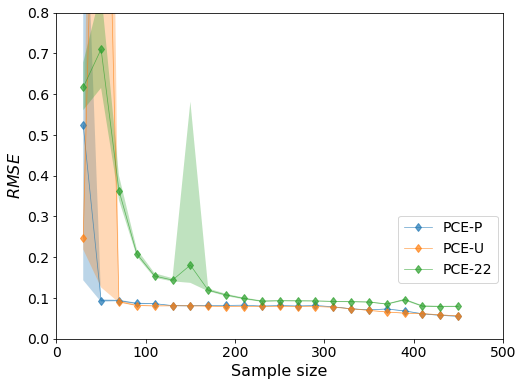

In [13]:
# Plot RMSE vs sample size
import matplotlib.ticker as mticker
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 6))
index_plot = np.array(np.arange(0, df.shape[0], 2))
xticks = [i for i in df['index'].values[index_plot]]
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[[1, 4, 7]], kind='line', marker='d',
                legend=False, logy=False, ax=axes, linewidth=0.7, alpha=0.7, logx=False)
for k in range(3):
    ax1.fill_between(df.loc[index_plot, 'index'], df.iloc[index_plot][df.columns[3*k + 2]].values, df.iloc[index_plot][df.columns[3*k + 3]].values, alpha=0.3)
ax1.legend(['PCE-P', 'PCE-U', 'PCE-22'], bbox_to_anchor=(0.75, 0.15), fontsize=14) # 'PCE-U',
ax1.set_ylabel(r'$RMSE$', fontsize = 16);
ax1.set_xlabel('Sample size', fontsize = 16);
ax1.set_ylim(0, 0.8)
ax1.set_xlim(0, 500)
ax1.set_xticklabels(xticks, fontsize=12);
# ticks_loc = ax1.get_yticks().tolist()
# ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels([np.round(i, 1) for i in ax1.get_yticks()], fontsize=14);
ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], fontsize=14);
plt.savefig(f'{output_path}/figure/adaptive_independent_validation_panel_1.png', dpi=300, format='png')

# generate the 1-1 scatter plot

In [4]:
# Calculate the error (RMSE) of PCE
product_uniform = ['exact', 'uniform', False] # 'uniform', 
rmse_all = {}
for p in product_uniform:
    dist_type = dist_return(p)
    filename = f'adaptive-reduce-{dist_type}_552'
    approx_list_all = pickle.load(open(f'{output_path}{filename}-approx-list.pkl', "rb"))
    
    for key, value in approx_list_all.items():
        if int(key.split('_')[1]) in [50, 150, 250, 350, 450]:
            rmse_exact = {}
            for ii in range(len(value)):
                pce = value[ii]
                if dist_type == 'full':
                    y_hat = pce(samples_22_vali)
                else:
                    y_hat = pce(samples_vali)
                
                rmse_exact[ii] = y_hat.flatten()
                
            rmse_all[f'{dist_type}{key}'] = pd.DataFrame.from_dict(rmse_exact).mean(axis=1).values

In [20]:
# Scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Text(0, 0.5, '$\\hat y$')

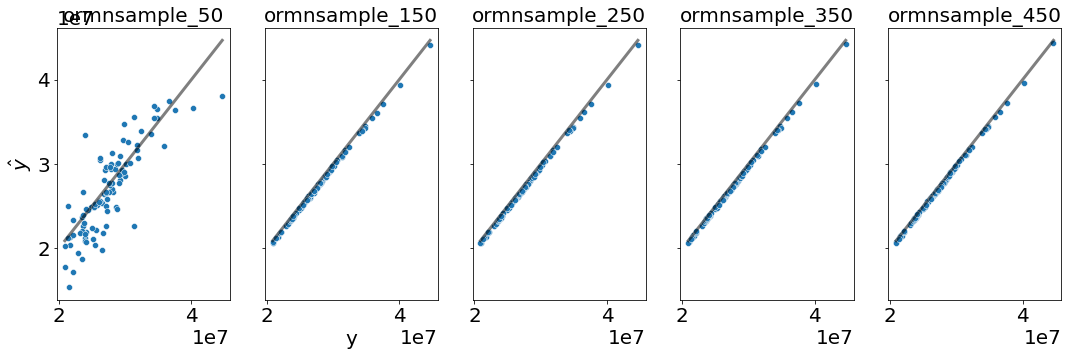

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18,5))
k = 0; dist_type = 'uniform' 
for key, y_hat in rmse_all.items():
    if dist_type in key:
        sns.scatterplot(x=values_vali.flatten(), y = y_hat, ax=axes[k])
        sns.lineplot(x=values_vali.flatten(), y=values_vali.flatten(), ax=axes[k], color='k', alpha=0.5)
        axes[k].set_title(key[4:])
        k += 1
axes[1].set_xlabel('y')
axes[0].set_ylabel(r'$\hat y$')
# plt.savefig(f'../output/adaptive/figure/pce_scatter_{dist_type}_data.png', dpi=300, format='png')

# plot the cross-validation RMSE

In [4]:

def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp

In [5]:
# Plot errors of cross-validation
from matplotlib import rcParams

# filepath = ['../output/paper0915/', '../output/paper0915/figure4/test_plot/', '../output/paper0915/figure4/test1013/']
filepath = ['../output/adaptive/']
filename = ['error_cv_exact_552.csv', 'error_cv_uniform_552.csv',  'error_cv_full_552.csv']

df_uniform = df_return(filepath[0], filename[0])
df_uniform = df_uniform.filter(items=['mean'])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_exact' for col in cols if col == 'mean'}, inplace=True)
df_22 = df_return(filepath[0], filename[2])
df_22 = df_22.filter(items=['mean'])
df_22.rename(columns={col: col+'_22' for col in cols}, inplace=True)

df_exact = df_return(filepath[0], filename[1])
df_exact = df_exact.filter(items=['mean'])
df_exact.rename(columns={col: 'mean_uni' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_exact, df_22], axis=1)

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
# plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

In [6]:
train_vals = pd.read_csv(filepath[0]+'samples_adjust.csv').values[:, -1]
xticks = np.array([int(i.split('_')[1]) for i in df['index'].values])
std_list = [train_vals[0:].std() for n in xticks]

In [7]:
# std_train_samples = int(4307583)
# calculate the relative RMSE which is the RMSE normalized by the standard deviation
df = df.fillna(0)
for col in df.columns[1:]:
    df.loc[:, col] = df.loc[:, col] / std_list
df = df.replace(0,np.nan)
# df.head()

<ipython-input-14-e4a537d5c769>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], fontsize=14);


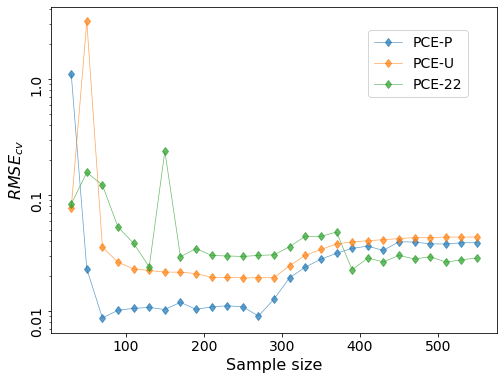

In [14]:
# Plot RMSE vs sample size
import matplotlib.ticker as mticker
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 6))
index_plot = np.array(np.arange(2, df.shape[0], 2))
# xticks = [int(i.split('_')[1]) for i in df['index'].values]
df['index'] = xticks
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[[1, 2, 3]], kind='line', marker='d',
                legend=True, logy=True, ax=axes, linewidth=0.7, alpha=0.7, logx=False)

ax1.legend(['PCE-P', 'PCE-U', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14) # 'PCE-U',
ax1.set_ylabel(r'$RMSE_{cv}$', fontsize = 16);
ax1.set_xlabel('Sample size', fontsize = 16);
# ax1.set_xlim(1, 10000)
# ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ticks_loc = ax1.get_yticks().tolist()
ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels(ax1.get_yticks(), rotation=90, fontsize=14);
ax1.set_xticklabels([int(i) for i in ax1.get_xticks()], fontsize=14);
plt.savefig(f'{output_path}/figure/adaptive_cross_validation_log.png', dpi=300, format='png')